In [1]:
import numpy as np
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from sklearn import metrics
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

In [2]:
ds_ch = pd.read_csv('./Downloads/week4day1/통신고객이탈.csv',encoding='CP949',engine='python')
ds_ch.head()
#타겟이 이산형

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [3]:
ds_ch.isnull().sum(axis=0)

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

In [10]:
ds_ch["CHURN"].replace(to_replace = "Active", value=0, inplace=True)
ds_ch["CHURN"].replace(to_replace = "Churned", value=1, inplace=True)

In [11]:
np.random.seed(seed=1234)
msk=np.random.rand(ds_ch.shape[0],)<0.7
ds_ch_train=ds_ch[msk]
ds_ch_test=ds_ch[~msk]

print("train data size: {}".format(ds_ch_train.shape))
print("test data size: {}".format(ds_ch_test.shape))

train data size: (635, 15)
test data size: (295, 15)


In [12]:
ds_ch_train=sm.add_constant(ds_ch_train)
ds_ch_train.head()

,const,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,1.0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,1.0,0,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,1.0,0,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
5,1.0,0,K105530,M,51,CAT 100,S80,Med,49.43,3,289,486.6,1,31.8,427,903.3
6,1.0,0,K106210,F,30,CAT 100,ASAD170,Med,32.30,6,427,729.6,12,52.8,490,907.2


In [32]:
log_model=sm.Logit.from_formula("""CHURN~C(GENDER)+AGE+C(CHARGE_TYPE)+C(HANDSET)+C(USAGE_BAND)\
+SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME ++ WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME\
+ TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""", ds_ch_train)
log_result=log_model.fit()
print(log_result.summary())

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [25]:
#DROPPED_CALLS 제외
log_model=sm.Logit.from_formula("""CHURN~C(GENDER)+AGE+C(CHARGE_TYPE)+C(HANDSET)+C(USAGE_BAND)\
+SERVICE_DURATION + PEAK_CALLS_NO + PEAK_CALLS_TIME ++ WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME\
+ TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""", ds_ch_train)
log_result=log_model.fit()
print(log_result.summary())

         Current function value: 0.256071
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  635
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                           28
Date:                Fri, 01 Feb 2019   Pseudo R-squ.:                  0.4766
Time:                        09:42:42   Log-Likelihood:                -162.61
converged:                      False   LL-Null:                       -310.70
                                        LLR p-value:                 1.399e-46
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -21.9046    872.286     -0.025      0.980   -1731.554    1687.744
C(GENDER)[T.M]   

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
#bfgs 방법,

log_model=sm.Logit.from_formula("""CHURN~C(GENDER)+AGE+C(CHARGE_TYPE)+C(HANDSET)+C(USAGE_BAND)\
+SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME ++ WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME\
+ TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""", ds_ch_train)
log_result=log_model.fit(method='bfgs')
print(log_result.summary())

         Current function value: 0.261293
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  635
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                           29
Date:                Fri, 01 Feb 2019   Pseudo R-squ.:                  0.4660
Time:                        09:46:11   Log-Likelihood:                -165.92
converged:                      False   LL-Null:                       -310.70
                                        LLR p-value:                 9.369e-45
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1342      2

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
y_pred=log_result.predict(ds_ch_test)
y_pred_class=(y_pred>0.5).astype(int)
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int64

In [34]:
print("Accuracy: {0:.3f}".format(metrics.accuracy_score(ds_ch_test["CHURN"],y_pred_class)))

Accuracy: 0.898


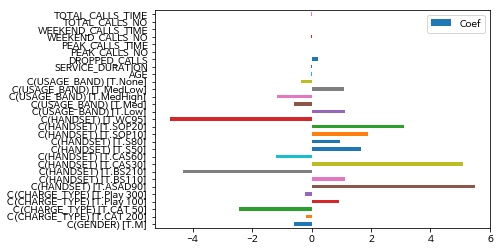

In [35]:
ds_logistic_coef=pd.DataFrame({"Coef":log_result.params.values[1:]}, index=log_model.exog_names[1:])
ds_logistic_coef.plot.barh(y="Coef")

In [36]:
ds_ch_char=ds_ch.select_dtypes(include="object")
ds_ch_numeric=ds_ch.select_dtypes(exclude="object")

ds_ch_char_train=ds_ch_char[msk]
ds_ch_numeric_scaled_train=scale(ds_ch_numeric[msk])
ds_ch_numeric_scaled_train=pd.DataFrame(ds_ch_numeric_scaled_train,columns=ds_ch_numeric.columns)
ds_ch_numeric_scaled_train.head()

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,-0.487665,-0.061287,-0.066658,0.936779,-0.050954,-0.622843,-0.431938,-0.777862,0.069711,-0.778293
1,-0.487665,-0.366521,-0.240702,2.073082,0.618542,-0.088273,-0.309382,-0.601091,0.247156,-0.454921
2,-0.487665,-0.366521,1.070294,2.357157,0.130457,-0.232062,-0.983441,-1.374462,-0.328554,-0.811538
3,-0.487665,1.464884,1.072417,0.084552,0.255718,-0.416436,-0.922163,-0.496134,0.310247,-0.286151
4,-0.487665,-0.137596,-0.139530,0.936779,0.851786,0.053197,-0.248104,0.083895,0.558670,-0.279066


In [37]:
ds_ch_numeric_scaled_train["CHURN"]=np.where(ds_ch_numeric_scaled_train["CHURN"]>0,1,0)
ds_ch_numeric_scaled_train.head()

ds_ch_scaled_train=pd.concat([ds_ch_numeric_scaled_train, ds_ch_char_train.reset_index(drop=True)], axis=1)
ds_ch_scaled_train

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,CUSTOMER_ID,GENDER,CHARGE_TYPE,HANDSET,USAGE_BAND
0,0,-0.061287,-0.066658,0.936779,-0.050954,-0.622843,-0.431938,-0.777862,0.069711,-0.778293,K102990,F,CAT 100,ASAD170,Med
1,0,-0.366521,-0.240702,2.073082,0.618542,-0.088273,-0.309382,-0.601091,0.247156,-0.454921,K103280,M,CAT 100,S50,Med
2,0,-0.366521,1.070294,2.357157,0.130457,-0.232062,-0.983441,-1.374462,-0.328554,-0.811538,K103660,M,CAT 100,ASAD170,Med
3,0,1.464884,1.072417,0.084552,0.255718,-0.416436,-0.922163,-0.496134,0.310247,-0.286151,K105530,M,CAT 100,S80,Med
4,0,-0.137596,-0.139530,0.936779,0.851786,0.053197,-0.248104,0.083895,0.558670,-0.279066,K106210,F,CAT 100,ASAD170,Med
5,0,1.541193,-1.646504,-0.767675,-0.642703,-0.038411,0.242121,0.249617,-0.703159,-0.213120,K107660,M,CAT 100,S80,Med
6,0,-0.290213,-1.469629,-0.767675,-0.076870,0.060154,-0.983441,-1.374462,-0.482339,-0.476903,K107820,F,CAT 100,S50,Med
7,0,-0.213904,1.237972,-0.767675,-0.500165,-0.205391,-0.983441,-1.374462,-0.782023,-0.617515,K109810,F,CAT 100,S80,Med
8,0,0.396564,1.171467,-0.199524,-0.940737,-0.236700,0.364677,-0.214406,-1.160572,-0.348282,K110630,F,CAT 100,S80,Med
9,0,1.083341,-0.356732,-0.767675,-0.979611,0.033484,-0.186826,-0.808244,-0.955525,-0.230923,K110700,M,CAT 100,S50,Med


         Current function value: 0.262450
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


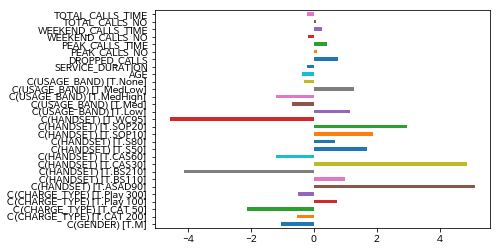

In [39]:
scaled_log_model=sm.Logit.from_formula("""CHURN~C(GENDER)+AGE+C(CHARGE_TYPE)+C(HANDSET)+C(USAGE_BAND)\
+SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME ++ WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME\
+ TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""",ds_ch_scaled_train)
scaled_log_result=scaled_log_model.fit(method='bfgs')
ds_log_scaled_coef=pd.DataFrame({"Coef": scaled_log_result.params.values[1:]},
                               index=scaled_log_model.exog_names[1:])
ds_log_scaled_coef.plot.barh(y="Coef",legend=False)